In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import *
from dysts_simulation import Rossler
from matplotlib.colors import TwoSlopeNorm
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from tqdm.auto import tqdm

from demo_utils import compute_lyaps


In [17]:
# param_list = [0.12, 0.24]

num_trajs = 2
n_periods = 20
pts_per_period = 500
T = n_periods*pts_per_period
param_list = [0.02, 0.24]
traj_offset_sd = 1e-3
random_state = 42
param_name = "a"
noise = 0
transient = int(0.1*T)
train_window = int(0.6*T)
test_window = int(0.3*T)
obs_noise = 0

trajectories = {}

eqs = {}
for param in param_list:
    params = dict(
        a=param,
        b=0.1,
        c=5.7
    )
    eq = Rossler(**params, random_state=random_state)
    eqs[param] = eq
    trajectories[param] = eq.make_trajectory(n_periods=n_periods, num_ics=num_trajs, pts_per_period=pts_per_period, noise=noise, traj_offset_sd=traj_offset_sd, verbose=True)
    trajectories[param] += np.random.randn(*trajectories[param].shape)*obs_noise
    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
# dt = eq.dt
dt = eq.period/pts_per_period
t_inds = np.arange(n_periods*pts_per_period)
t_eval = t_inds*dt

train_inds = np.arange(transient, transient + train_window)
test_inds = np.arange(transient + train_window, transient + train_window + test_window)

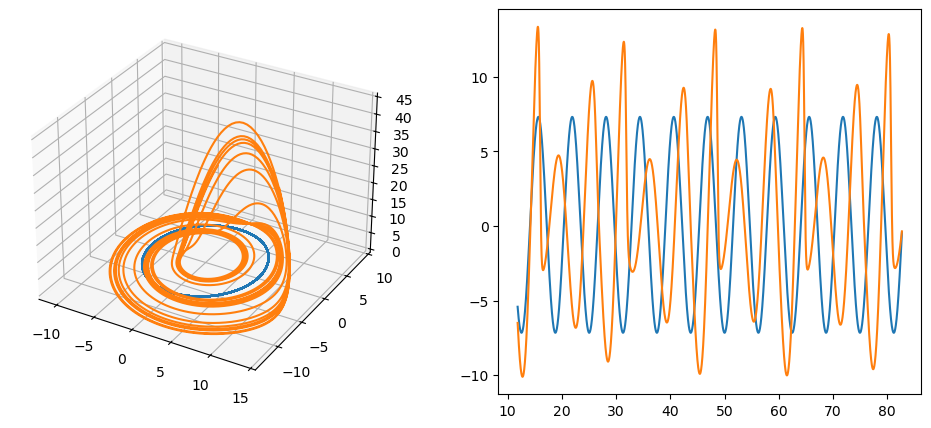

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
traj_num = -1
axs[0].remove()
axs[0] = fig.add_subplot(1, 2, 1, projection='3d')
for param, x in trajectories.items():
    ax = axs[0]
    ax.plot(x[traj_num, :, 0], x[traj_num, :, 1], x[traj_num, :, 2])

    ax = axs[1]
    ax.plot(t_eval[train_inds], x[traj_num, train_inds, 0])
plt.show()

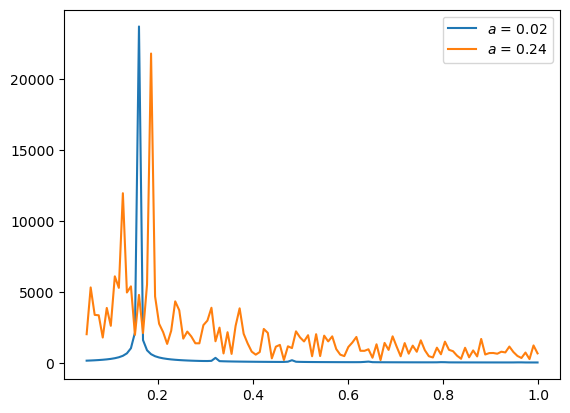

In [20]:
max_freq = 1
min_freq = 0.05

for param, x in trajectories.items():
    fft_mag = np.abs(np.fft.rfft(x.transpose(0, 2, 1).reshape(-1, x.shape[1]))).mean(axis=0)
    freqs = np.fft.rfftfreq(x.shape[1], d=dt)
    freq_inds = (freqs >= min_freq) & (freqs <= max_freq)
    plt.plot(freqs[freq_inds], fft_mag[freq_inds], label=fr"${param_name}$ = {param}")
plt.legend()
plt.show()

In [21]:
jacobians = {}

# time_inds_jac = train_inds
time_inds_jac = t_inds

for param, x in trajectories.items():
    eq = eqs[param]
    jacs = np.zeros((num_trajs, len(time_inds_jac), 3, 3))
    for num_traj in range(num_trajs):
        # if param == 0.02:
        #     raise ValueError
        jacs[num_traj] = np.array([eq.jac(x[num_traj, t], t*dt) for t in time_inds_jac])
    jacobians[param] = jacs

In [22]:
lyaps = {}
for param, jacobian_mats in tqdm(jacobians.items()):
    lyap_vals = np.zeros((num_trajs, 3))
    for num_traj in range(num_trajs):
        lyap_vals[num_traj] = compute_lyaps(np.eye(3) + dt*jacobian_mats[num_traj], dt=dt)
        # lyap_vals[num_traj] = compute_lyapunov_exponents(np.eye(3) + dt*jacobian_mats[num_traj], dt=dt)
    lyaps[param] = lyap_vals

  0%|          | 0/2 [00:00<?, ?it/s]

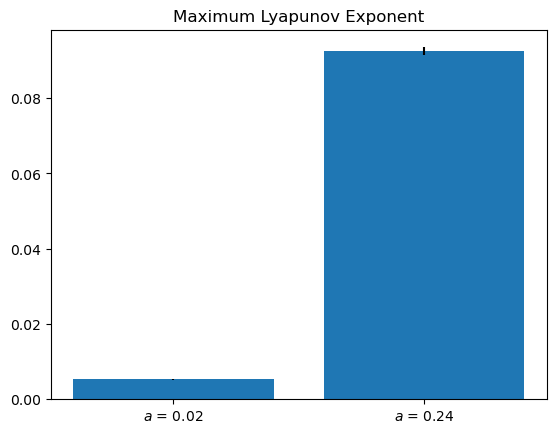

In [23]:
# num_to_plot = 1
# for param in param_list:
#     # print(f"{param_name}={param}: {lyaps[param].mean(axis=0)}")
#     plt.errorbar(
#         np.arange(lyaps[param].shape[1])[:num_to_plot] + 1, 
#         lyaps[param].mean(axis=0)[:num_to_plot], 
#         yerr=lyaps[param].std(axis=0)[:num_to_plot]/np.sqrt(lyaps[param].shape[0]),
#         fmt='o',  # Marker only, no line
#         label=fr"${param_name}$ = {param}")
# plt.legend()
# plt.xlim([0.98, 1.02])
# plt.xlabel("Lyapunov exponent #")


max_lyap_means = [lyaps[param][:, 0].mean() for param in param_list]
max_lyap_ses = [lyaps[param][:, 0].std()/np.sqrt(lyaps[param].shape[0]) for param in param_list]
labels = [fr"${param_name}$ = {param}" for param in param_list]
plt.bar(labels, max_lyap_means, yerr=max_lyap_ses)

plt.title('Maximum Lyapunov Exponent')

plt.show()

# Stability Analysis

In [40]:
max_freq = (1/(dt))/2

n_delays_vals = np.arange(1, 16)
rank_vals = np.arange(1, 16)


all_delase_results = []

iterator = tqdm(total=num_trajs*len(param_list)*len(n_delays_vals)*len(rank_vals))

for num_traj in range(num_trajs):
    # print("-"*20)
    # print(f"NUM_TRAJ = {num_traj}")
    delase_results = {}
    
    for param in param_list:
        # print("-"*20)
        # print(f"MU = {mu}")
        x = trajectories[param]
        x = x[num_traj]
        # x = x[::subsample]
        x = x[:, [0]]
        
        aic_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        mase_mat = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat3 = np.zeros((len(n_delays_vals), len(rank_vals)))
        stab_mean_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat3 = np.zeros((len(n_delays_vals), len(rank_vals)))
        delase_evals_mat10p = np.zeros((len(n_delays_vals), len(rank_vals)))
        
        for i, n_delays in enumerate(n_delays_vals):
            delase = DeLASE(x[train_inds], n_delays=n_delays, rank=n_delays*x.shape[-1], dt=dt, max_freq=max_freq, max_unstable_freq=max_freq, device='cuda')
            delase.DMD.compute_hankel()
            delase.DMD.compute_svd()
            for j, rank in enumerate(rank_vals):
                if rank <= n_delays*x.shape[-1]:
                    
                    delase.DMD.compute_havok_dmd(rank=rank)
                    preds = delase.DMD.predict(x[test_inds])
                    aic_mat[i, j] = float(aic(torch.from_numpy(x[test_inds]).cuda(), preds, k=rank**2).cpu().numpy())
                    mase_mat[i, j] = float(mase(torch.from_numpy(x[test_inds]).cuda(), preds).cpu().numpy())
                    delase.get_stability()
                    stab_mean_mat3[i, j] = delase.stability_params[:3].mean().cpu().numpy()
                    num_params = np.min((int(0.1*len(delase.stability_params)), rank))
                    num_params = np.max([num_params, 1])
                    stab_mean_mat10p[i, j] = delase.stability_params[:num_params].mean().cpu().numpy()

                    I = torch.eye(delase.DMD.A_havok_dmd.shape[0]).cuda()
                    evals = torch.linalg.eigvals((delase.DMD.A_havok_dmd - I)/dt)
                    evals, freqs = torch.real(evals), torch.imag(evals)/(2*np.pi)
                    sort_inds = torch.flip(torch.sort(evals).indices, dims=(0,))
                    evals, freqs = evals[sort_inds], freqs[sort_inds]
                    freq_inds = freqs <= max_freq
                    evals = evals[freq_inds]
                    freqs = freqs[freq_inds]
                    delase_evals_mat3[i, j] = evals[:3].mean().cpu().numpy()
                    num_evals = np.min((int(0.1*len(evals)), rank))
                    num_evals = np.max([num_evals, 1])
                    delase_evals_mat10p[i, j] = evals[:num_evals].mean().cpu().numpy()
                    
                else:
                    aic_mat[i, j] = np.inf
                    mase_mat[i, j] = np.inf
                iterator.update()
    
        delase_results[param] = dict(
            train_inds=train_inds,
            test_inds=test_inds,
            aic_mat=aic_mat,
            mase_mat=mase_mat,
            stab_mean_mat3=stab_mean_mat3,
            stab_mean_mat10p=stab_mean_mat10p,
            delase_evals_mat3=delase_evals_mat3,
            delase_evals_mat10p = delase_evals_mat10p
        )

    all_delase_results.append(delase_results)
    
iterator.close()

  0%|          | 0/900 [00:00<?, ?it/s]

In [41]:
params_to_use = param_list
# params_to_use = [0.02, 0.24]

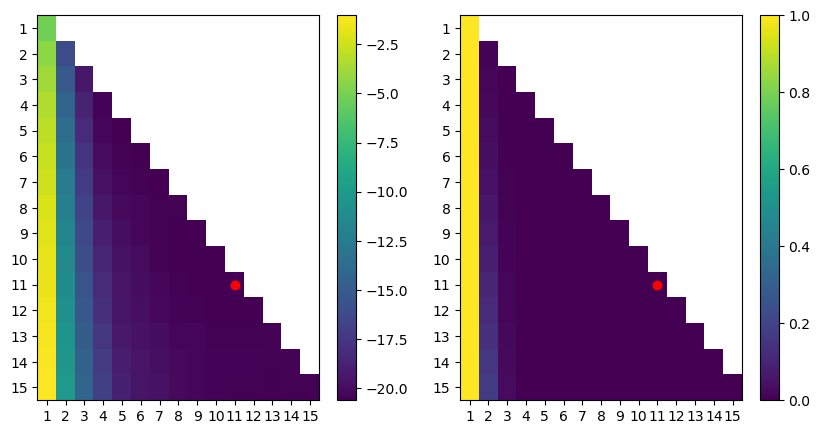

In [42]:
aic_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
mase_mat_all = np.ones((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        aic_mat_all[num_traj, ind] = delase_results[param]['aic_mat']
        mase_mat_all[num_traj, ind] = delase_results[param]['mase_mat']
# aic_mat /= len(rhos_to_use)
aic_mat = aic_mat_all.mean(axis=(0, 1))
mase_mat = mase_mat_all.mean(axis=(0, 1))
i, j = np.unravel_index(aic_mat.argmin(), shape=aic_mat.shape)
n_delays = n_delays_vals[i]
rank = rank_vals[j]
# n_delays = 200
# rank = 15
# rank = 12
# rank = 8
# j = np.where(np.array(rank_vals) == rank)[0][0]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
im = ax.imshow(aic_mat, aspect='auto')
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)

ax = axs[1]
norm = TwoSlopeNorm(vmin=0, vcenter=0.5, vmax=1)
im = ax.imshow(mase_mat, aspect='auto', norm=norm)
ax.scatter(j, i, c='r')
ax.set_xticks(np.arange(len(rank_vals)), rank_vals)
ax.set_yticks(np.arange(len(n_delays_vals)), n_delays_vals)
fig.colorbar(im, ax=ax)
plt.show()

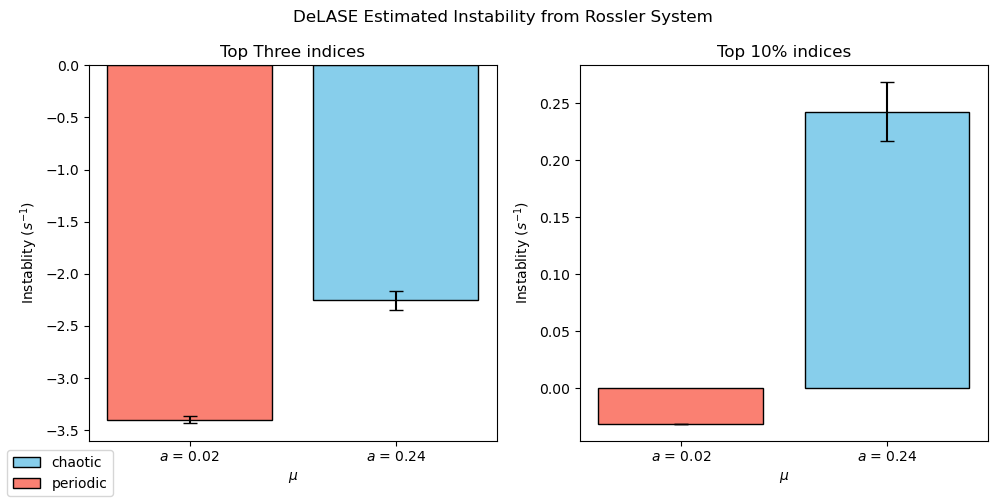

In [43]:
stab_means_3 = np.zeros((num_trajs, len(params_to_use)))
stab_means_10p = np.zeros((num_trajs, len(params_to_use)))
delase_evals_3 = np.zeros((num_trajs, len(params_to_use)))
delase_evals_10p = np.zeros((num_trajs, len(params_to_use)))

for num_traj in range(num_trajs):
    delase_results = all_delase_results[num_traj]
    for ind, param in enumerate(params_to_use):
        stab_means_3[num_traj, ind] = delase_results[param]['stab_mean_mat3'][i, j]
        stab_means_10p[num_traj, ind] = delase_results[param]['stab_mean_mat10p'][i, j]
        delase_evals_3[num_traj, ind] = delase_results[param]['delase_evals_mat3'][i, j]
        delase_evals_10p[num_traj, ind] = delase_results[param]['delase_evals_mat10p'][i, j]

# Create the scatter plot with error bars

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if param == np.max(params_to_use) else 'salmon' for param in params_to_use]

ax = axs[0]
mean_vals = stab_means_3.mean(axis=0)
se_vals = stab_means_3.std(axis=0)/np.sqrt(stab_means_3.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top Three indices")

ax = axs[1]
mean_vals = stab_means_10p.mean(axis=0)
se_vals = stab_means_10p.std(axis=0)/np.sqrt(stab_means_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("DeLASE Estimated Instability from Rossler System")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'periodic'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
fig.legend(handles=legend_handles, loc='lower left')
plt.tight_layout()
plt.show()

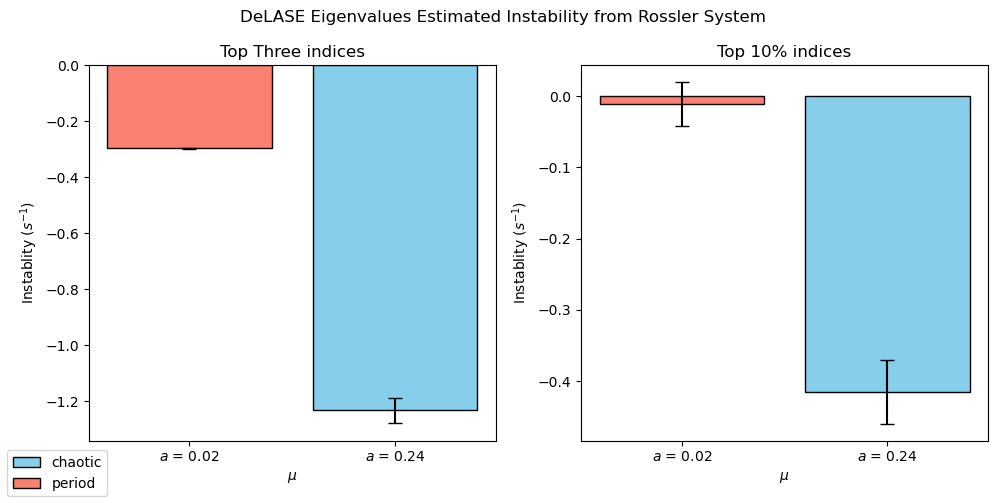

In [44]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plt.errorbar(np.arange(len(pairs_to_use)), mean_vals, yerr=se_vals, fmt='o', ecolor='r', capsize=5)
colors = ['skyblue' if param == np.max(params_to_use) else 'salmon' for param in params_to_use]

ax = axs[0]
mean_vals = delase_evals_3.mean(axis=0)
se_vals = delase_evals_3.std(axis=0)/np.sqrt(delase_evals_3.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top Three indices")

ax = axs[1]
mean_vals = delase_evals_10p.mean(axis=0)
se_vals = delase_evals_10p.std(axis=0)/np.sqrt(delase_evals_10p.shape[0])
ax.bar(np.arange(len(params_to_use)), mean_vals, yerr=se_vals, capsize=5, color=colors, edgecolor='black')
ax.set_xticks(np.arange(len(params_to_use)), [fr"${param_name}$ = {param}" for param in params_to_use])

ax.set_xlabel("$\mu$")
ax.set_ylabel("Instablity ($s^{-1}$)")
ax.set_title("Top 10% indices")

fig.suptitle("DeLASE Eigenvalues Estimated Instability from Rossler System")

# Create legend
legend_labels = {'chaotic': "chaotic", 'stable': 'period'}
legend_handles = [plt.Rectangle((0,0),1,1, color='skyblue', ec='black', lw=1, label=legend_labels['chaotic']),
                  plt.Rectangle((0,0),1,1, color='salmon', ec='black', lw=1, label=legend_labels['stable'])]
fig.legend(handles=legend_handles, loc='lower left')
plt.tight_layout()
plt.show()

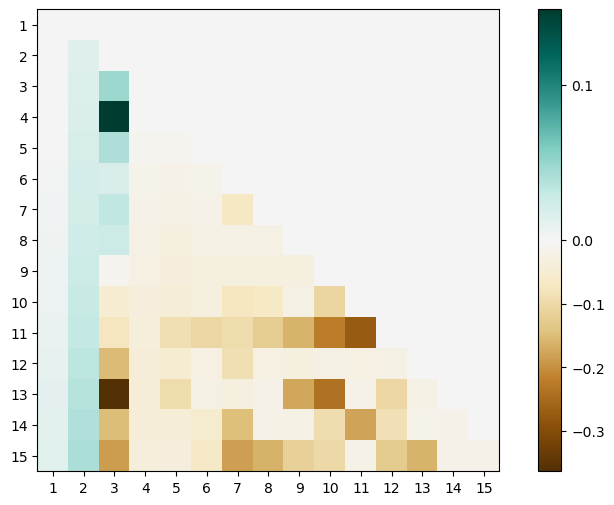

In [45]:
stab_means_all = np.zeros((num_trajs, len(params_to_use), len(n_delays_vals), len(rank_vals)))
# delase_evals_all = np.zeros((num_trajs, len(rhos_to_use), len(n_delays_vals), len(rank_vals)))
for i in range(len(n_delays_vals)):
    for j in range(len(rank_vals)):
        for num_traj in range(num_trajs):
            delase_results = all_delase_results[num_traj]
            for ind, param in enumerate(params_to_use):
                stab_means_all[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
                # stab_means_all[num_traj, ind] = delase_results[param]['stab_mean_mat10p']
            

# fig, axs = plt.subplots(len(n_delays_vals), len(rank_vals), figsize=(20, 12))

stab_all_mean = stab_means_all.mean(axis=0)
stab_all_se = stab_means_all.std(axis=0)/np.sqrt(num_trajs)

diff = stab_all_mean[0] - stab_all_mean[1]
norm = TwoSlopeNorm(vmin=diff.min(), vcenter=0, vmax=diff.max())
# norm = TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5)
plt.figure(figsize=(10, 6))
plt.imshow(diff, cmap='BrBG', norm=norm)
plt.xticks(np.arange(len(rank_vals)), rank_vals)
plt.yticks(np.arange(len(n_delays_vals)), n_delays_vals)
plt.colorbar()

plt.show()

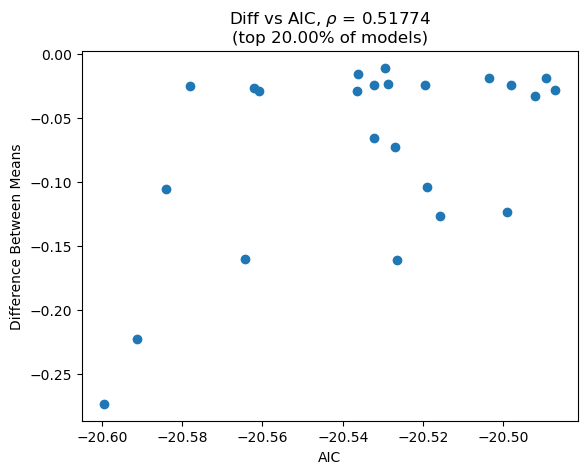

In [51]:
top_percent = 0.2
aic_min = aic_mat[aic_mat < np.inf].min()
aic_max = np.percentile(aic_mat[aic_mat < np.inf], top_percent*100)
aic_all = aic_mat[aic_mat < np.inf].flatten()
diff_all = diff[aic_mat < np.inf].flatten()
aic_inds = (aic_all >= aic_min) & (aic_all <= aic_max)

plt.scatter(aic_all[aic_inds], diff_all[aic_inds] )
plt.xlabel('AIC')
plt.ylabel('Difference Between Means')

# lr = LinearRegression().fit(aic_all[aic_inds].reshape(-1, 1), diff_all[aic_inds].reshape(-1, 1))
# rho = np.sqrt(lr.score(aic_all[aic_inds].reshape(-1, 1), diff_all[aic_inds].reshape(-1, 1)))
rho = pearsonr(aic_all[aic_inds], diff_all[aic_inds]).statistic
# print(lr.coef_)
plt.title(fr"Diff vs AIC, $\rho$ = {rho:.5f}"+ f"\n(top {top_percent*100:.2f}% of models)")

plt.show()